# LightFM warp loss in detail

Like the BPR model, WARP deals with (user, positive item, negative item) triplets. Unlike BPR, the negative items in the triplet are not chosen by random sampling: they are chosen from among those negatie items which would violate the desired item ranking given the state of the model. This approximates a form of active learning where the model selects those triplets that it cannot currently rank correctly.

This procedure yields roughly the following algorithm:

1. For a given (user, positive item pair), sample a negative item at random from all the remaining items. Compute predictions for both items; if the negative item’s prediction exceeds that of the positive item plus a margin, perform a gradient update to rank the positive item higher and the negative item lower. If there is no rank violation, continue sampling negative items until a violation is found.

2. If you found a violating negative example at the first try, make a large gradient update: this indicates that a lot of negative items are ranked higher than positives items given the current state of the model, and the model must be updated by a large amount. If it took a lot of sampling to find a violating example, perform a small update: the model is likely close to the optimum and should be updated at a low rate.


In [22]:
# comment: how does ang treats overfitting in interaction loss graphics
# It seams to have a problem when running in sequence
# remove num_threads for proper argumentation

In [2]:
import time
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score

movielens = fetch_movielens()
train, test = movielens['train'], movielens['test']

### AUC comparison

In [24]:
alpha = 1e-5
epochs = 70
num_components = 32

In [25]:
warp_model = LightFM(no_components= num_components,
                    loss= 'warp',
                    learning_schedule = 'adagrad',
                    max_sampled =100,
                    user_alpha = alpha,
                    item_alpha = alpha)

bpr_model = LightFM(no_components= num_components,
                    loss= 'bpr',
                    learning_schedule = 'adagrad',
                    user_alpha = alpha,
                    item_alpha = alpha)

In [26]:
warp_duration=[]
warp_auc=[]
bpr_duration=[]
bpr_auc=[]

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train,epochs=1, num_threads=4)
    warp_duration.append(time.time()-start)
    warp_auc.append(auc_score(warp_model,test,train_interactions=train).mean())
    
for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train,epochs=1, num_threads=4)
    bpr_duration.append(time.time()-start)
    bpr_auc.append(auc_score(bpr_model,test,train_interactions=train).mean())

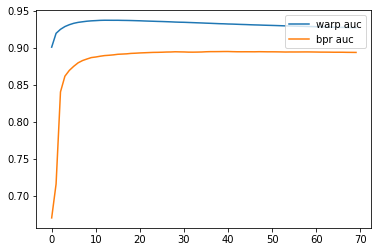

In [27]:
x=np.arange(epochs)
plt.plot(x,np.array(warp_auc))
plt.plot(x,np.array(bpr_auc))
plt.legend(['warp auc', 'bpr auc'], loc = 'upper right')
plt.show()

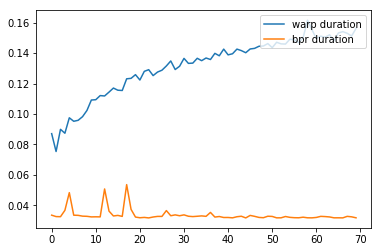

In [28]:
x = np.arange(epochs)
plt.plot(x,np.array(warp_duration))
plt.plot(x,np.array(bpr_duration))
plt.legend(['warp duration', 'bpr duration'], loc = 'upper right')
plt.show()

### warp takes more time to find negative examples when the model is better adjusted

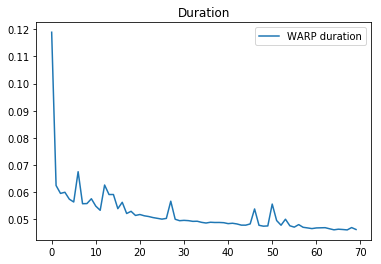

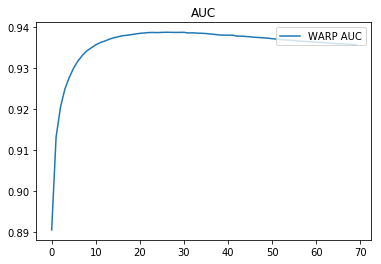

In [30]:
warp_model = LightFM(no_components=num_components,
                     max_sampled=3,
                    loss='warp',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
warp_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.legend(['WARP duration'], loc='upper right')
plt.title('Duration')
plt.show()

x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.legend(['WARP AUC'], loc='upper right')
plt.title('AUC')
plt.show()